# Figure 1 : Forme des potentiels d'actions
# NB : Les données sont très lourdes et ne sont donc pas sur le Github, mais disponible sur demande par mail
Basé sur la méthode de https://www.cell.com/neuron/fulltext/S0896-6273(09)00720-X?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS089662730900720X%3Fshowall%3Dtrue#app2

Qui classifie les neurones avec trois paramètres de la forme des potentiels d'actions, en utilisant 5 pénétrations différentes pour maximiser le nombres de neurones. 

Chacun des blocs de code ci-dessous sort les informations d'un bloc de neurones, ce qui n'est pas très élégant de manière algorithmique mais qui permet de mieux controler le processus pour s'assurer que les inférences que nous faisons sur la nature des neurones est solide. 

Certains blocs ont des contrôles d'erreur, d'autres non. Ces bouts de codes sont présents dans les derniers blocs, après 80h d'enregistrement car les signaux sont devenus bruités et ne peuvent pas être gardés pour analyse

In [1]:
%matplotlib inline

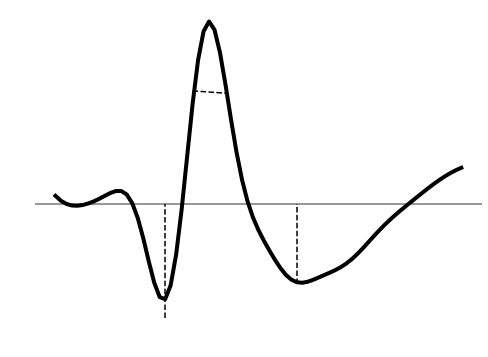

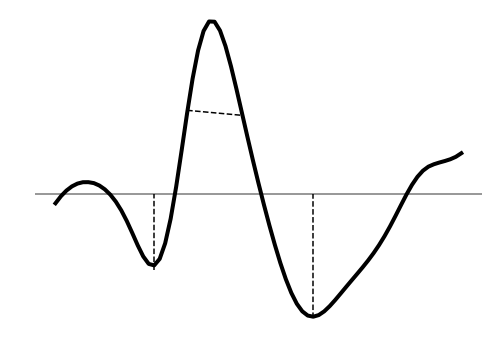

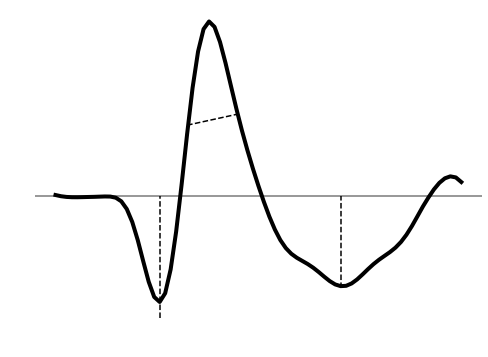

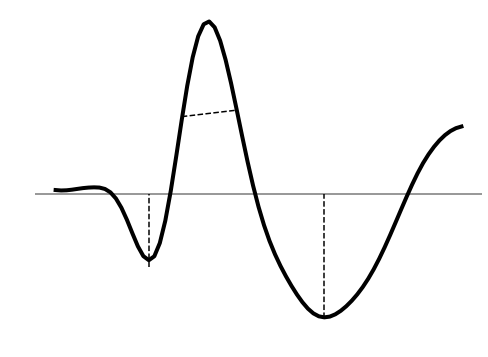

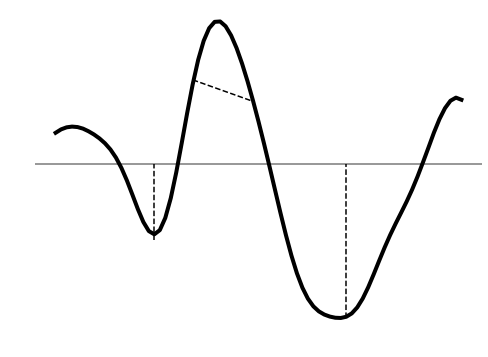

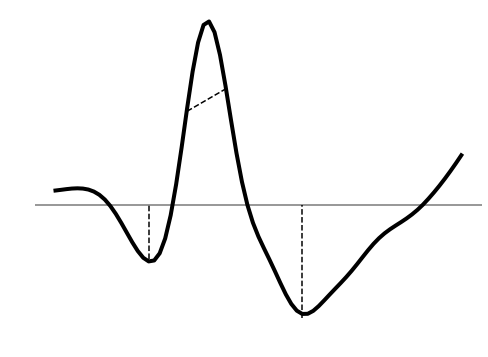

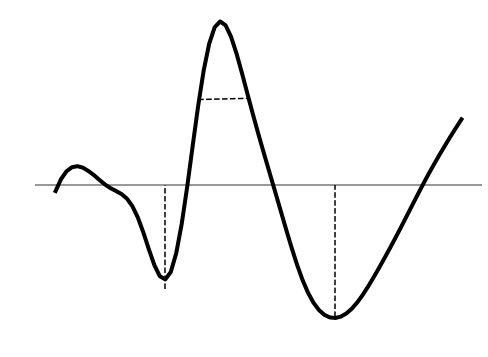

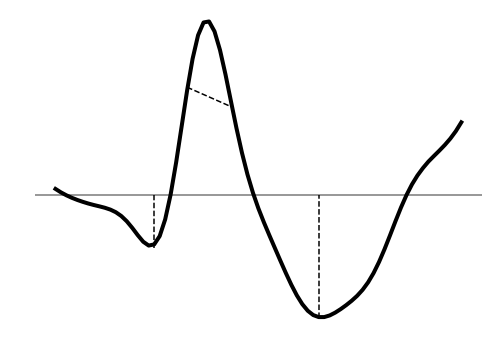

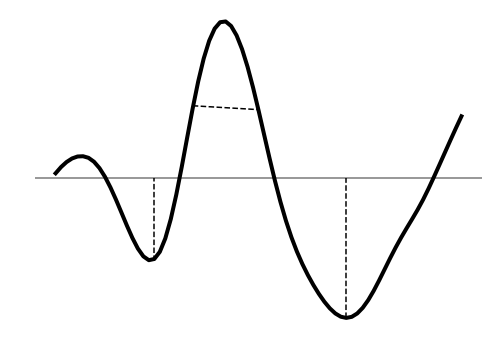

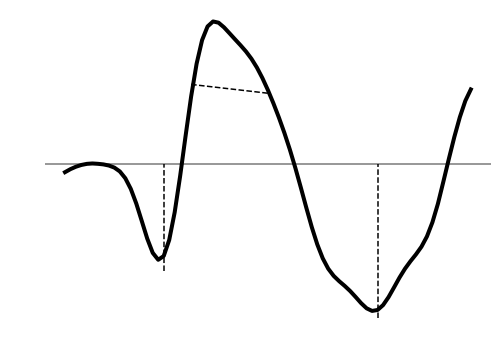

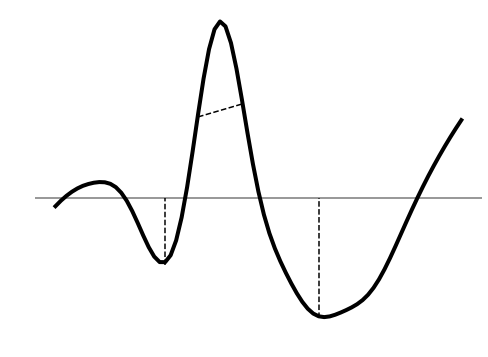

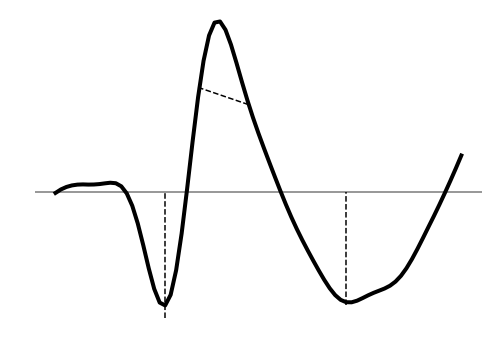

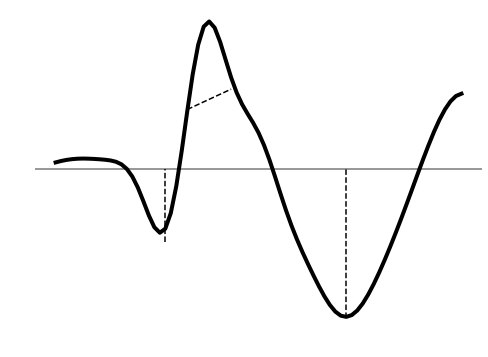

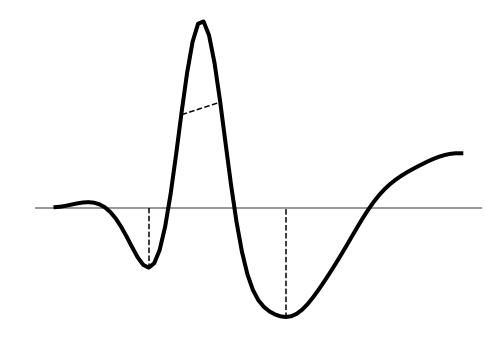

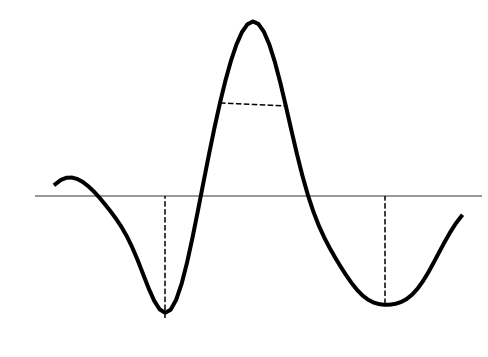

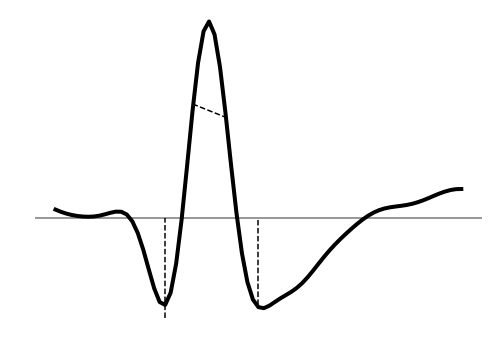

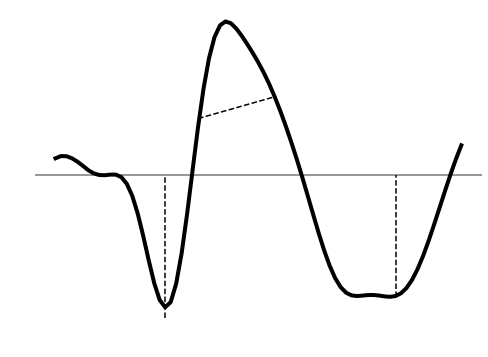

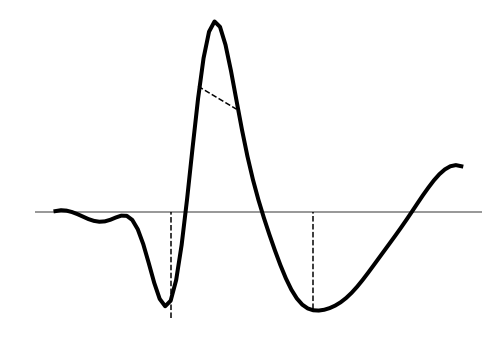

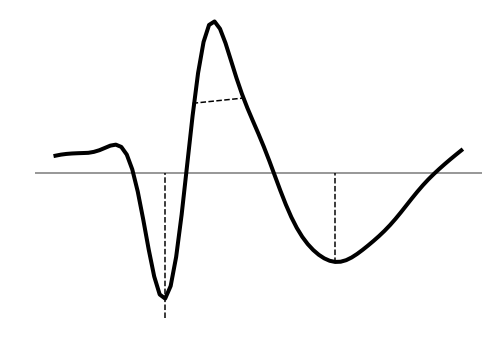

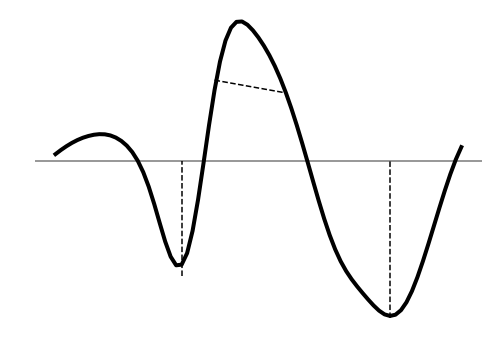

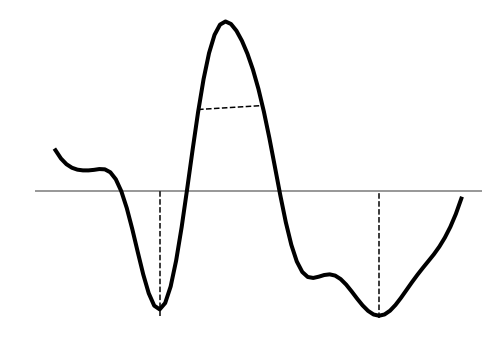

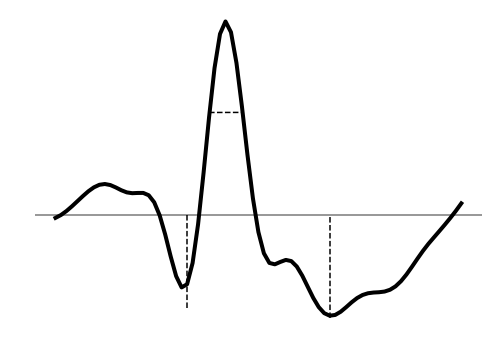

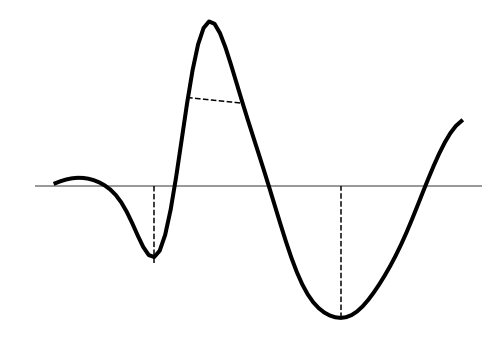

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from tqdm import tqdm
import csv

#Filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Find nearest point
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


# Parameters
folder = '../A006_a17/'
num_spikes_to_extract = 1000
window = 30

clust_chan_tuples = [(81,31),
                    (77,30),
                    (83,29),
                    (69,28),
                    (46,27),
                    (80,26),
                    (96,25),
                    (91, 24),
                    (95, 23),
                    (2, 22),
                    (94, 21),
                    (97, 20),
                    (72,19),
                    (66, 18),
                    (30, 18),
                    (74,17),
                    (92,16),
                    (88,15),
                    (85,14),
                    (86,13),
                    (17,12),
                    (64, 11),
                    (82,10)]

fs = 30000.0
lowcut = 300.0
highcut = 3000.0
order = 6

# Open raw file
f = open(folder + 'converted_data.bin', "r")
a = np.fromfile(f, dtype=np.int16)
a = np.reshape(a, (-1, 32))

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

#Main loop, average waveforms and get points
mean_waveforms = []
carac_points = []
for cluster_tuple in clust_chan_tuples :
    cluster_channel = cluster_tuple[1] - 1
    index_cluster = cluster_groups.index(cluster_tuple[0])

    y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
    waveform_list = []
    for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
        beg = int(spikes-(window/2))
        end = int(spikes+(2*window))
        #print(beg, end)
        waveform_list.append(y[beg:end])

    mean_waveform = np.mean(waveform_list, axis = 0)
    mean_waveforms.append(mean_waveform)

    #get the peak
    max_amp = np.max(mean_waveform)
    max_amp_time = np.where(mean_waveform == max_amp)[0]
    middle = max_amp_time[0]

    #get the two lowest points
    first_min_amp = np.min(mean_waveform[:middle])
    first_min_time = np.where(mean_waveform == first_min_amp)[0]

    second_min_amp = np.min(mean_waveform[middle:])
    second_min_time = np.where(mean_waveform == second_min_amp)[0]

    
    #get the FWHM
    first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
    second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

    first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
    second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]
    
    from scipy.signal import savgol_filter
    yhat = savgol_filter(mean_waveform, 13, 3) # window size 7, polynomial order 3
    #plotting time
    fig = plt.figure(figsize = (8,6))
    plt.axhline(0, c = 'gray', linewidth = 2, alpha = .8)
    plt.plot((first_min_time, first_min_time), (first_min_amp, 0), c = 'k', linestyle = '--')
    plt.plot((second_min_time, second_min_time), (second_min_amp, 0), c = 'k', linestyle = '--')
    plt.plot((first_half_peak_time, second_half_peak_time), (first_half_peak, second_half_peak), c = 'k', linestyle = '--')
    
    plt.plot(yhat, c = 'k', linewidth = 4, label = 'Mean Waveform')

    plt.axis('off')
    plt.pause(.05)
    #fig.savefig('mean_%s.svg'%cluster_channel, format = 'svg')
    #compute the three coordinates for classification
    half_width = second_half_peak_time - first_half_peak_time
    trough_to_peak = second_min_time -max_amp_time
    peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)
    
    carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])

In [6]:
plt.axhline?

In [2]:
# Parameters
folder = 'B007_a17/'


clust_chan_tuples = [(76,31), (73,30), (64,29), (72,28), (75,27), (77,26), (87, 25), (82, 23), (80, 22), (96,21), (99,19),
(90,18), (94, 17), (71, 16,), (85, 14), (88,14), (86,13), (91,12), (98, 12), (84, 11), (97,10), (95,9)]

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

for cluster_tuple in tqdm(clust_chan_tuples) :
    cluster_channel = cluster_tuple[1] - 1
    index_cluster = cluster_groups.index(cluster_tuple[0])

    y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
    waveform_list = []
    for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
        beg = int(spikes-(window/2.2))
        end = int(spikes+(2*window))
        #print(beg, end)
        waveform_list.append(y[beg:end])

    mean_waveform = np.mean(waveform_list, axis = 0)
    mean_waveforms.append(mean_waveform)

    #get the peak
    max_amp = np.max(mean_waveform)
    max_amp_time = np.where(mean_waveform == max_amp)[0]
    middle = max_amp_time[0]

    #get the two lowest points
    first_min_amp = np.min(mean_waveform[:middle])
    first_min_time = np.where(mean_waveform == first_min_amp)[0]

    second_min_amp = np.min(mean_waveform[middle:])
    second_min_time = np.where(mean_waveform == second_min_amp)[0]

    
    #get the FWHM
    first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
    second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

    first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
    second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]

    #compute the three coordinates for classification
    half_width = second_half_peak_time - first_half_peak_time
    trough_to_peak = second_min_time -max_amp_time
    peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)
    
    carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])

100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


In [3]:
# Parameters
folder = 'E007_a17/'

clust_chan_tuples = [(101,31), (79,29), (76, 27), (71, 26), (83, 24), (88, 23), (89, 21), (78, 20), (42, 18), (87,17), (97,15),
(39,13), (95,12), (100,11), (99,9), (93, 8), (96,7), (94,6), (90,4)]

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

for cluster_tuple in tqdm(clust_chan_tuples) :
    try :
        cluster_channel = cluster_tuple[1] - 1
        index_cluster = cluster_groups.index(cluster_tuple[0])

        y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
        waveform_list = []
        for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
            beg = int(spikes-(window/2.2))
            end = int(spikes+(2*window))
            #print(beg, end)
            waveform_list.append(y[beg:end])

        mean_waveform = np.mean(waveform_list, axis = 0)
        mean_waveforms.append(mean_waveform)

        #get the peak
        max_amp = np.max(mean_waveform)
        max_amp_time = np.where(mean_waveform == max_amp)[0]
        middle = max_amp_time[0]


        #get the two lowest points
        first_min_amp = np.min(mean_waveform[:middle])
        first_min_time = np.where(mean_waveform == first_min_amp)[0]

        second_min_amp = np.min(mean_waveform[middle:])
        second_min_time = np.where(mean_waveform == second_min_amp)[0]


        #get the FWHM
        first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
        second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

        first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
        second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]

        #compute the three coordinates for classification
        half_width = second_half_peak_time - first_half_peak_time
        trough_to_peak = second_min_time -max_amp_time
        peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)

        carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])
    except :
        print('Noisy signal detected, skipping waveform')

 95%|█████████▍| 18/19 [00:16<00:00,  1.10it/s]

Noisy signal detected, skipping waveform


100%|██████████| 19/19 [00:17<00:00,  1.10it/s]

Noisy signal detected, skipping waveform


In [4]:
# Parameters
folder = 'F005_a17/'

clust_chan_tuples = [(73, 31), (91, 30), (79, 29), (77, 28), (69, 27), (65, 26), (88, 25), (64, 23), (93, 22), (85,21),
(80, 19), (61, 17), (97, 14), (92, 13), (96,10), (83,8)] 

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

for cluster_tuple in tqdm(clust_chan_tuples) :
    cluster_channel = cluster_tuple[1] - 1
    index_cluster = cluster_groups.index(cluster_tuple[0])

    y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
    waveform_list = []
    for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
        beg = int(spikes-(window/2.2))
        end = int(spikes+(2*window))
        #print(beg, end)
        waveform_list.append(y[beg:end])

    mean_waveform = np.mean(waveform_list, axis = 0)
    mean_waveforms.append(mean_waveform)

    #get the peak
    max_amp = np.max(mean_waveform)
    max_amp_time = np.where(mean_waveform == max_amp)[0]
    middle = max_amp_time[0]

    #get the two lowest points
    first_min_amp = np.min(mean_waveform[:middle])
    first_min_time = np.where(mean_waveform == first_min_amp)[0]

    second_min_amp = np.min(mean_waveform[middle:])
    second_min_time = np.where(mean_waveform == second_min_amp)[0]

    
    #get the FWHM
    first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
    second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

    first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
    second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]

    #compute the three coordinates for classification
    half_width = second_half_peak_time - first_half_peak_time
    trough_to_peak = second_min_time -max_amp_time
    peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)
    
    carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])

100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


In [5]:
# Parameters
folder = 'G006_a17/'

clust_chan_tuples = [(73, 31), (86, 30), (93, 29), (65, 27), (50,27), (88,25), (82, 24), (80, 23), (83, 22), (89, 20),
(99, 18), (94, 17), (95, 16), (91, 15), (97,14), (78,13), (84, 11), (98, 11), (90,9), (74,8)]

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

for cluster_tuple in tqdm(clust_chan_tuples) :
    try :
        cluster_channel = cluster_tuple[1] - 1
        index_cluster = cluster_groups.index(cluster_tuple[0])

        y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
        waveform_list = []
        for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
            beg = int(spikes-(window/2.2))
            end = int(spikes+(2*window))
            #print(beg, end)
            waveform_list.append(y[beg:end])

        mean_waveform = np.mean(waveform_list, axis = 0)
        mean_waveforms.append(mean_waveform)

        #get the peak
        max_amp = np.max(mean_waveform)
        max_amp_time = np.where(mean_waveform == max_amp)[0]
        middle = max_amp_time[0]


        #get the two lowest points
        first_min_amp = np.min(mean_waveform[:middle])
        first_min_time = np.where(mean_waveform == first_min_amp)[0]

        second_min_amp = np.min(mean_waveform[middle:])
        second_min_time = np.where(mean_waveform == second_min_amp)[0]


        #get the FWHM
        first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
        second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

        first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
        second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]

        #compute the three coordinates for classification
        half_width = second_half_peak_time - first_half_peak_time
        trough_to_peak = second_min_time -max_amp_time
        peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)

        carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])
    except :
        print('Noisy signal detected, skipping waveform')

 45%|████▌     | 9/20 [00:08<00:09,  1.10it/s]

Noisy signal detected, skipping waveform


100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


In [6]:
# Parameters
folder = 'H005_a17/'

clust_chan_tuples = [ (81, 29), (80, 28), (86, 25), (90, 23), (66,22), (91,21), (74,19), (77, 18), (88,18),
(69, 17), (70, 17), (76, 16), (78, 15), (79,14), (83,13), (73,9)]

# Load spikes
spike_times = np.load(folder+'spike_times.npy')
spike_clusters = np.load(folder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(folder+'cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))
good_spikes = []
for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0])

    good_spikes.append(temp_lst)

for cluster_tuple in tqdm(clust_chan_tuples) :
    try :
        cluster_channel = cluster_tuple[1] - 1
        index_cluster = cluster_groups.index(cluster_tuple[0])

        y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
        waveform_list = []
        for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
            beg = int(spikes-(window/2.2))
            end = int(spikes+(2*window))
            #print(beg, end)
            waveform_list.append(y[beg:end])

        mean_waveform = np.mean(waveform_list, axis = 0)
        mean_waveforms.append(mean_waveform)

        #get the peak
        max_amp = np.max(mean_waveform)
        max_amp_time = np.where(mean_waveform == max_amp)[0]
        middle = max_amp_time[0]


        #get the two lowest points
        first_min_amp = np.min(mean_waveform[:middle])
        first_min_time = np.where(mean_waveform == first_min_amp)[0]

        second_min_amp = np.min(mean_waveform[middle:])
        second_min_time = np.where(mean_waveform == second_min_amp)[0]


        #get the FWHM
        first_half_peak = find_nearest(mean_waveform[first_min_time[0]:max_amp_time[0]], max_amp/2)
        second_half_peak = find_nearest(mean_waveform[max_amp_time[0]:second_min_time[0]], max_amp/2)

        first_half_peak_time = np.where(mean_waveform == first_half_peak)[0]
        second_half_peak_time = np.where(mean_waveform == second_half_peak)[0]

        #compute the three coordinates for classification
        half_width = second_half_peak_time - first_half_peak_time
        trough_to_peak = second_min_time -max_amp_time
        peak_amplitude_asymetry = (second_min_amp - first_min_amp) / (second_min_amp + first_min_amp)

        carac_points.append([half_width, trough_to_peak, peak_amplitude_asymetry])
    except :
        print('Noisy signal detected, skipping waveform')

 62%|██████▎   | 10/16 [00:08<00:05,  1.12it/s]

Noisy signal detected, skipping waveform


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


On visualise en 3D les points qui permettent de classifier les neurones en IN/PC

#remove one outlier 
index_to_del = np.where(carac_points == np.max(carac_points))[0][0]
carac_points.pop(index_to_del)


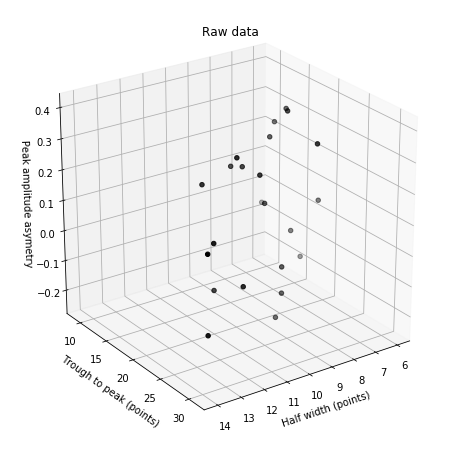

In [3]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for triplets in carac_points :
    xs.append(triplets[0][0])
    ys.append(triplets[1][0])
    zs.append(triplets[2])
    
ax.scatter(xs, ys, zs, c='k')

ax.set_xlabel('Half width (points)')
ax.set_ylabel('Trough to peak (points)')
ax.set_zlabel('Peak amplitude asymetry')


ax.set_title('Raw data')

ax.view_init(elev=25, azim=55)
plt.show()

In [4]:
zs_mod = zs.copy()
carac_mod = carac_points.copy()

outliers = np.where(zs_mod >= .1*np.std(zs_mod))
print(outliers)
for out in outliers[0] :
    print(out)
    del carac_mod[out]

(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 19, 21, 22]),)
1
3
4
5
6
7
8
9
10
12
13


IndexError: list assignment index out of range

In [5]:
zs_mod = []
for points in carac_mod :
    zs_mod.append(points[2])

outliers = np.where(zs_mod >= 1*np.std(zs_mod))
print(outliers)
for out in outliers[0] :
    print(out)
    del carac_mod[out]

(array([ 2,  3,  4,  7, 12]),)
2
3
4
7
12


IndexError: list assignment index out of range

In [6]:
zs_mod = []
for points in carac_mod :
    zs_mod.append(points[2])
outliers = np.where(zs_mod <=  -2.5*np.std(zs_mod))
print(outliers)
for out in outliers[0] :
    print(out)
    del carac_mod[out]

(array([], dtype=int64),)


In [7]:
zs_mod = []
for points in carac_mod :
    zs_mod.append(points[2])
outliers = np.where(zs_mod <=  -2*np.std(zs_mod))
print(outliers)
for out in outliers[0] :
    print(out)
    del carac_mod[out]

(array([], dtype=int64),)


In [8]:
len(carac_mod)

9

In [9]:
len(carac_points)

23

In [10]:
carac_mod[73]

IndexError: list index out of range

In [11]:
carac_points[74]

IndexError: list index out of range

Maintenant on clusterise avec Kmeans. Le premier graph est celui de l'elbow method, qui permet de trouver iterativement la meilleure quantité de clusters pour le classificateur.

In [12]:
arr = np.asarray(carac_points)

Text(0.5, 1.0, 'Optimal Cluster search with elbow method')

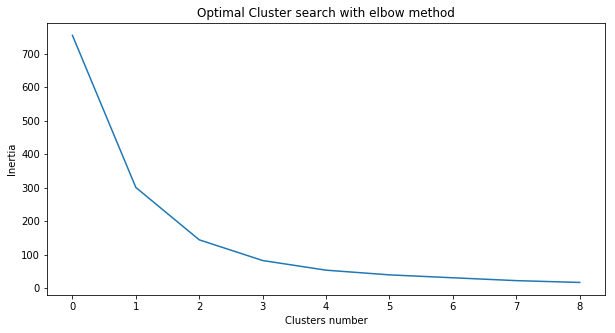

In [13]:
from sklearn import cluster

# elbow method
sses = []
for k in range(1, 10):
    kmeans = cluster.KMeans(n_clusters=k, init='k-means++',
                            n_init=100, max_iter=1000).fit(arr)
    sses.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(sses)
plt.xlabel('Clusters number')
plt.ylabel('Inertia')
plt.title('Optimal Cluster search with elbow method')

In [44]:
%matplotlib notebook

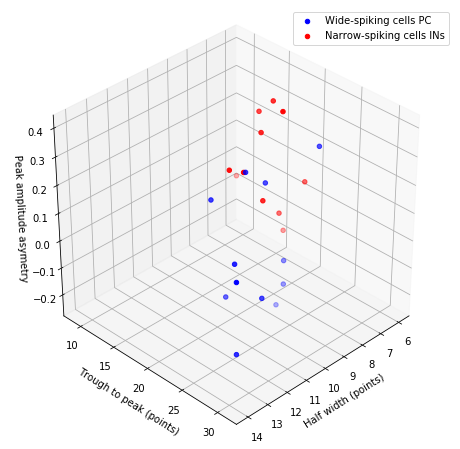

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

n_clusters = 2
kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',
                        n_init=10, max_iter=1000).fit(arr)

first_class_triplets = []
second_class_triplets = []

for i in range(len(kmeans.labels_)) :
    if kmeans.labels_[i] == 0 :
        first_class_triplets.append(arr[i])
    else :
        second_class_triplets.append(arr[i])

xs1, ys1, zs1 = [], [], []
for i in first_class_triplets :
        xs1.append(i[0][0])
        ys1.append(i[1][0])
        zs1.append(i[2])
        
xs2, ys2, zs2 = [], [], []
for i in second_class_triplets:
        xs2.append(i[0][0])
        ys2.append(i[1][0])
        zs2.append(i[2])

ax.scatter(xs2, ys2, zs2,
           c = 'b', label = 'Wide-spiking cells PC')
ax.scatter(xs1, ys1, zs1,
           c = 'r', label = 'Narrow-spiking cells INs')

ax.set_xlabel('Half width (points)')
ax.set_ylabel('Trough to peak (points)')
ax.set_zlabel('Peak amplitude asymetry')


ax.view_init(elev=35, azim=45)
plt.legend()
plt.show()

In [15]:
arr = np.column_stack((xs, ys))

In [27]:
%matplotlib inline

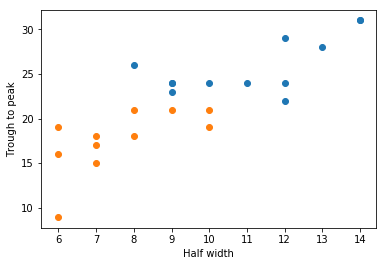

In [16]:
n_clusters = 2
kmeans = cluster.KMeans(n_clusters=n_clusters, init='random',
                        n_init=10, max_iter=100).fit(arr)

first_class_triplets = []
second_class_triplets = []

for i in range(len(kmeans.labels_)) :
    if kmeans.labels_[i] == 0 :
        first_class_triplets.append(arr[i])
    else :
        second_class_triplets.append(arr[i])
        
plt.scatter(*zip(*first_class_triplets))
plt.scatter(*zip(*second_class_triplets))

plt.xlabel('Half width')
plt.ylabel('Trough to peak')
plt.show()

In [17]:
len(xs2)/len(xs1)

1.0909090909090908

In [30]:
len(xs2)

24

In [31]:
len(xs1)

81

Un petit sanity check pour verifier que tout se ressemble avant de plotter à nouveau :

In [ ]:
len(clust_chan_tuples) == arr.shape[0] == len(kmeans.labels_)

In [ ]:
a ?

Et maintenant on plotte et enregistre les waveforms pour faire la figure

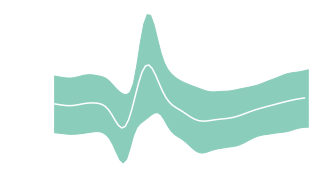

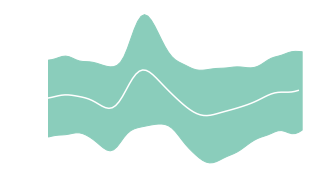

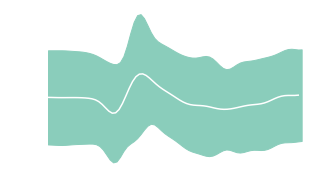

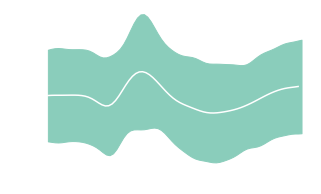

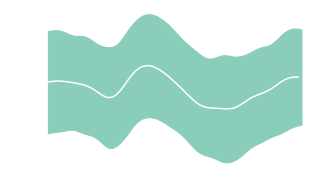

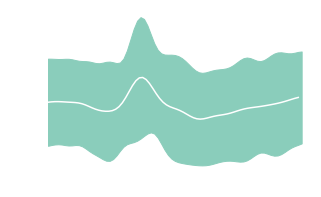

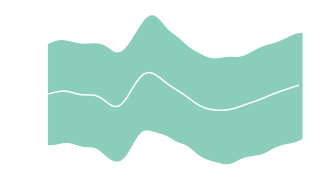

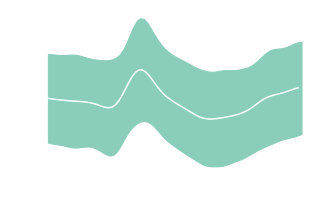

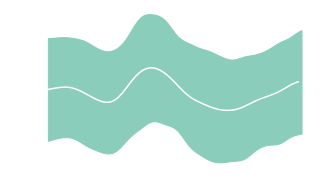

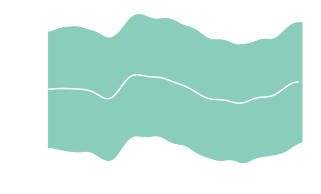

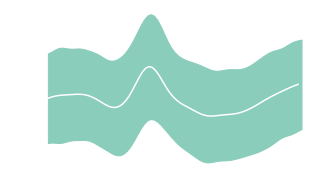

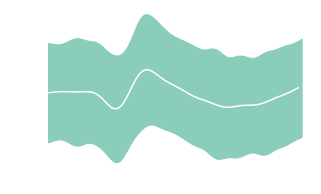

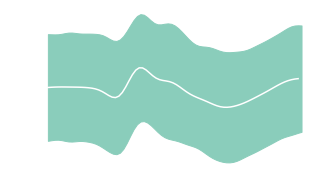

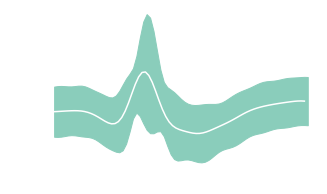

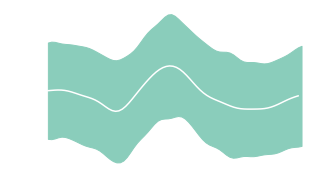

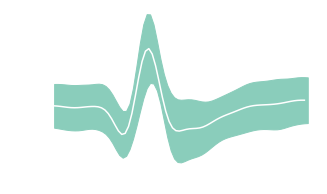

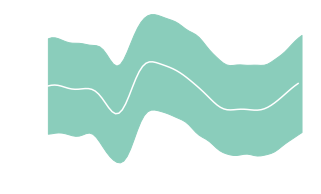

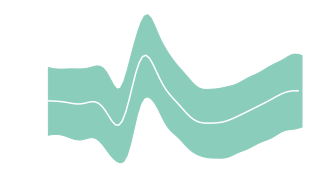

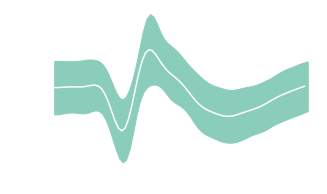

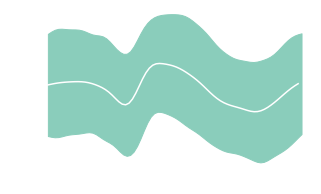

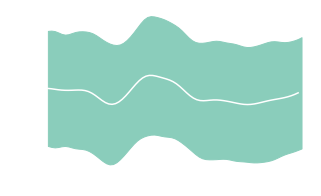

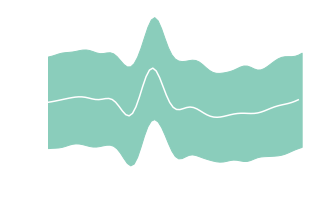

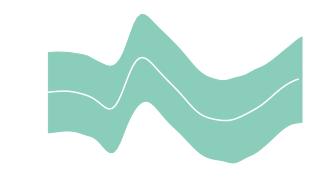

In [18]:
#### Main loop, average waveforms and get points

num_spikes_to_extract = 1000 
mean_waveforms = []
carac_points = []
for it, cluster_tuple in enumerate(clust_chan_tuples) :
    cluster_channel = cluster_tuple[1] - 1
    index_cluster = cluster_groups.index(cluster_tuple[0])

    y = butter_bandpass_filter(a[:, cluster_channel], lowcut, highcut, fs, order)
    waveform_list = []
    for spikes in good_spikes[index_cluster][10:num_spikes_to_extract]: #remove the first one to avoid bugs
        beg = int(spikes-(window/2))
        end = int(spikes+(2*window))
        #print(beg, end)
        waveform_list.append(y[beg:end])

    mean_waveform = np.mean(waveform_list, axis = 0)
    mean_waveforms.append(mean_waveform)
    std_waveform = np.std(waveform_list, axis = 0)
    
    #plotting time
    fig = plt.figure(figsize = (5,3))
    plt.axis('off')

    plt.plot(mean_waveform, c = 'w')
    
    if kmeans.labels_[it] == 1 :
        plt.fill_between(np.linspace(0, len(mean_waveform), len(mean_waveform)) ,
                         mean_waveform - std_waveform,  
                         mean_waveform + std_waveform, color='#8acdbb') 
    else :
        plt.fill_between(np.linspace(0, len(mean_waveform), len(mean_waveform)) ,
                         mean_waveform - std_waveform,  
                         mean_waveform + std_waveform, color='#8acdbb') 

    plt.pause(.005)
    fig.savefig('a%s.svg'%cluster_channel, format = 'svg', transparent = True)